Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 135s 677ms/step - accuracy: 0.5694 - loss: 1.0283 - val_accuracy: 0.7788 - val_loss: 0.5741
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 71s 380ms/step - accuracy: 0.7817 - loss: 0.5774 - val_accuracy: 0.8078 - val_loss: 0.4977
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 71s 380ms/step - accuracy: 0.8184 - loss: 0.4829 - val_accuracy: 0.8192 - val_loss: 0.4928
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 70s 377ms/step - accuracy: 0.8250 - loss: 0.4685 - val_accuracy: 0.8383 - val_loss: 0.4349
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 70s 375ms/step - accuracy: 0.8378 - loss: 0.4407 - val_accuracy: 0.8307 - val_loss: 0.4810
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 70s 375ms/step - accuracy: 0.8423 - loss: 0.4171 - val_accuracy: 0.8497 - val_loss: 0.4164
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 70s 375ms/step - accuracy: 0.8489 - loss: 0.4080 - val_accuracy: 0.8474 - val_loss: 0.4181
Epoch 8/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 69s 370ms/step - accuracy: 0.8520 - loss: 0.3903 - va

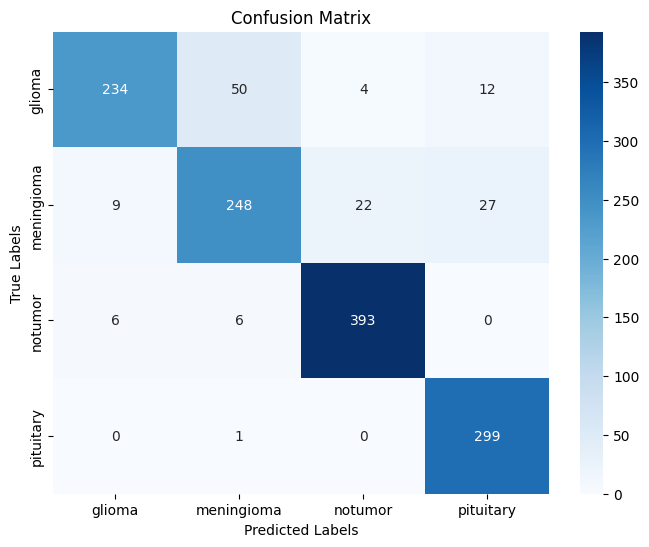

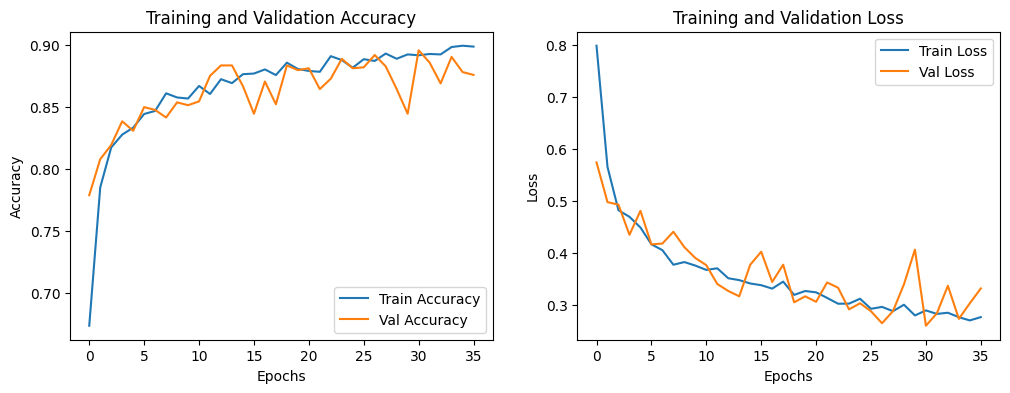

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

# Define the dataset path (modify this as needed)
data_path = "/kaggle/input/brain-tumor-mri-dataset"
train_dir = os.path.join(data_path, 'Training')
test_dir = os.path.join(data_path, 'Testing')

# Parameters
img_size = (224, 224)
batch_size = 32
epochs = 50
learning_rate = 0.0001

# Data augmentation and preprocessing
datagen_train = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

datagen_test = ImageDataGenerator(rescale=1.0/255)

train_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = datagen_test.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load pre-trained model (VGG16) without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Build the model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=epochs,
    callbacks=[early_stopping, checkpoint]
)

# Evaluate the model
eval_result = model.evaluate(test_generator)
print(f"Test Loss: {eval_result[0]:.4f}, Test Accuracy: {eval_result[1]:.4f}")

# Classification report and confusion matrix
predictions = np.argmax(model.predict(test_generator), axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("\nClassification Report:\n")
print(classification_report(true_classes, predictions, target_names=class_labels))

print("\nConfusion Matrix:\n")
conf_matrix = confusion_matrix(true_classes, predictions)
print(conf_matrix)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [5]:
model.save('finally_brain_tumor_model.keras', save_format='keras')